In [2]:
using JuMP
using HiGHS
import Random 
using Plots 
using LinearAlgebra
import MathOptInterface as MOI

ArgumentError: ArgumentError: Package JuMP not found in current path.
- Run `import Pkg; Pkg.add("JuMP")` to install the JuMP package.

In [3]:
rng = Random.MersenneTwister(1234);

## One fake house which everyone hates to reflect an empty allocation  
function generate_prefs(n,h)
    prefs = zeros(h+1, n)
    for i=1:n 
        prefs[1:h, i] = Random.shuffle(rng, 1:h)
    end 
    prefs[h+1, :] .= h+1 
    return prefs 
end 


function generate_caps(h, m_cap)
    caps = zeros(h+1)
    caps[1:h] = rand(1:m_cap, h) 
    caps[h+1] = Inf 
    return caps 
end 

function limited_lot_house!(prefs, all, house, cap, used, k) 
    n = size(prefs)[2]
    n_changed = 0 
    lottery = []
    for pp=1:n
        h = all[pp]
        my_score = prefs[h, pp] 
        upgrade = prefs[house, pp]
        if upgrade < k && upgrade < my_score 
            push!(lottery, pp) 
        end 
    end 
    Random.shuffle!(lottery)
    while used[house] < cap[house] && length(lottery) > 0 
        lucky = pop!(lottery) 
        old = all[lucky]
        used[old] -= 1
        all[lucky] = house 
        used[house] += 1 
        n_changed += 1 
    end 
    return n_changed 
end 

function limited_lottery_round!(prefs, all, cap, used,k)
    n_changed = 0 
    n_houses = size(prefs)[1]
    for h=1:n_houses
        if used[h] == cap[h] 
            continue
        end 
        n_changed += limited_lot_house!(prefs, all, h, cap, used,k)
    end 
    return n_changed
end 

function limited_lottery!(prefs, all, cap, used,k)
    n_changed = 1 
    total = 0 

    while n_changed != 0 
        n_changed = limited_lottery_round!(prefs, all, cap, used,k)
        total += 1
    end 
    return total
end 

function lottery_round_house!(prefs, all, house, cap, used)
    n = size(prefs)[2]
    n_changed = 0 
    lottery = []
    for pp=1:n
        h = all[pp]
        #my_score = findfirst( prefs[:, pp] .== h )
        #upgrade =  findfirst( prefs[:, pp] .== house)
        my_score = prefs[h, pp] 
        upgrade = prefs[house, pp]
        if my_score > upgrade 
            push!(lottery, pp) 
        end 
    end 
    Random.shuffle!(lottery)
    while used[house] < cap[house] && length(lottery) > 0 
        lucky = pop!(lottery) 
        old = all[lucky]
        used[old] -= 1
        all[lucky] = house 
        used[house] += 1 
        n_changed += 1 
    end 
    return n_changed 
end 

function lottery_round!(prefs, all, cap, used)
    n_changed = 0 
    n_houses = size(prefs)[1]
    for h=1:n_houses
        if used[h] == cap[h] 
            continue
        end 
        n_changed += lottery_round_house!(prefs, all, h, cap, used)
    end 
    return n_changed
end 

function lottery!(prefs, all, cap, used)
    n_changed = 1 
    total = 0 

    while n_changed != 0 
        n_changed = lottery_round!(prefs, all, cap, used)
        total += 1
    end 
    return total
end 



function score(prefs, allo)
    total = 0 
    n = length(allo)
    for i=1:n 
        total += prefs[allo[i], i] 
    end 
    return total 
end 

function score_numeric(prefs_num, prefs, all) 
    total = 0 
    n = size(prefs)[2]
    
    for i=1:n 
        place =  findfirst( prefs[:, i] .== all[i]) 
        total += prefs_num[place, i]
    end  
    return total 
end    





UndefVarError: UndefVarError: Random not defined

In [4]:
function rand_all!(allo, cap)
    n = length(allo) 
    h = length(cap) 
    head = 1 
    for j=1:h 
       used = 0 
       while head < n && used < cap[j]
            allo[head] = j 
            head += 1 
            used += 1
       end 
    end  
end


rand_all! (generic function with 1 method)

In [5]:
n = 5000
houses = 200
prefs = generate_prefs(n, houses)
#caps = generate_caps(houses, 30)
caps = ones(houses+1)
caps[1:houses] .= 30
caps[houses+1] = Inf 
allo = (houses + 1) * ones(Int32, n)
used[houses+1] = n  


usage = zeros(houses)
orig_caps = copy(caps)

n_rounds = 1 

UndefVarError: UndefVarError: used not defined

In [102]:
ns = i=1:50
score_n = zeros(length(ns))
n_trials = 10
for i=1:length(ns)
    n = 300*ns[i]
    houses = Int(n/30)
    for j = 1:n_trials
        prefs = generate_prefs(n, houses)
        caps = ones(houses+1)
        caps[1:houses] .= 30
        caps[houses+1] = Inf 
        allo = (houses + 1) * ones(Int32, n)
        used = zeros(houses+1)
        used[houses+1] = n  
        lottery!(prefs, allo, caps, used)
        score_n[i] += score(prefs, allo)
    end 
    score_n[i] = score_n[i] /(n_trials*n) 
end 


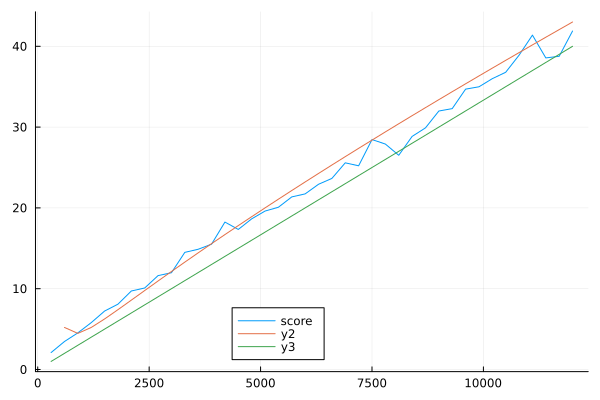

In [101]:
plot(300*ns, score_n, label="score")
plot!(300*ns, map(x ->  4.75*x *(1/ log(x)) - 8.5, ns ), legend=:bottom)
plot!(300*ns, ns)

In [12]:
function reset!(allo, used, caps, n, houses)
    allo .= (houses +1)
    used .= 0 
    used[houses+1] = 1 
end 

reset! (generic function with 1 method)

In [51]:
reset!(allo, used, caps, n, houses)

1

In [52]:
util = zeros(houses)
util2 = zeros(houses)
util5p = zeros(houses)
utilrand = zeros(houses)
usage = zeros(houses)
used = zeros(houses+1)

reset!(allo, used, caps, n, houses)
for i=1:200
    caps[1:i] .= 0 
    for k=1:n_rounds
        lottery!(prefs, allo, caps, used)
        util[i] = score(prefs, allo)/n
        reset!(allo, used, caps, n, houses)
        caps[1:i] .= 0 
        limited_lottery!(prefs, allo, caps, used, 2) 
        util2[i] = score(prefs, allo)/n
        usage[i] = (sum(used[1:houses]))/n 
        reset!(allo, used, caps, n, houses)
        caps[1:i] .= 0 
        rand_all!(allo, caps)
        utilrand[i] = score(prefs, allo)/n
        reset!(allo, used, caps, n, houses) 
        global caps = copy(orig_caps)

    end 
    
end 



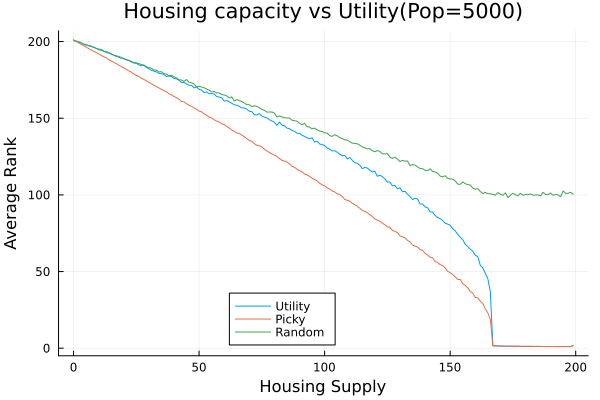

In [53]:
x_axis = (houses)*ones(houses) - [i for i=1:200]
plot()
plot(x_axis , util, label="Utility", legend=:bottom)
plot!(x_axis, util2, label="Picky")
#plot!(x_axis, usage, color="red", label="usage rate")

plot!(x_axis, utilrand, label="Random")


title!("Housing capacity vs Utility(Pop="*string(n) *")")
xlabel!("Housing Supply")
ylabel!("Average Rank")


In [54]:
opts = zeros(10)

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In this model being selective is better for everyone. Because there are fewer applicants in each pool? 

In [56]:
200 - (5000/30)

33.33333333333334

In [75]:
caps[1:33] .= 30

c  = [1, 10, 25, 30, 33,
      34, 35, 37, 40, 50,
      60, 70, 80, 90, 100]

m = length(c)
opts = zeros(m)

15-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [86]:
caps[1:houses] .= 30

200-element view(::Vector{Float64}, 1:200) with eltype Float64:
 30.0
 30.0
 30.0
 30.0
 30.0
 30.0
 30.0
 30.0
 30.0
 30.0
  ⋮
 30.0
 30.0
 30.0
 30.0
 30.0
 30.0
 30.0
 30.0
 30.0

In [87]:
for i=1:m
    caps[1:c[i]] .= 0 
    model = Model(HiGHS.Optimizer)
    all2 = zeros(houses+1, n )
    @variable(model, 0 <= all2[1:houses+1, 1:n] <= 1 )
    #@variable(model, 0 <= all2[1:houses+1, 1:n] <= 1)
    @objective(model, Min, sum( all2 .* prefs) / n )
    for i=1:n
        @constraint(model,  sum(all2[1:houses+1, i]) == 1)
    end 
    # for i=1:n 
    #     @constraint(model, all2[1:houses, i]' * prefs[1:houses, i] <= prefs[all[i], i] )
    # end 
    for j=1:houses
        @constraint(model,  sum(all2[j, 1:n]) <= caps[j] )
    end 
    optimize!(model)
    opts[i] = objective_value(model)
end 
    


Running HiGHS 1.5.1 [date: 1970-01-01, git hash: 93f1876e4]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
5199 rows, 1000000 cols, 1995000 nonzeros
5199 rows, 1000000 cols, 1995000 nonzeros
Presolve : Reductions: rows 5199(-1); columns 1000000(-5000); elements 1995000(-10000)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 5000(5000) 2s
       5123     1.0236000000e+00 Pr: 0(0); Du: 0(1.65341e-18) 2s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 5123
Objective value     :  1.0236000000e+00
HiGHS run time      :          3.02
Running HiGHS 1.5.1 [date: 1970-01-01, git hash: 93f1876e4]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
5190 rows, 955000 cols, 1905000 nonzeros
5190 rows, 955000 cols, 1905000 nonzeros
Presolve : Reductions: rows 5190(-10); columns 955000(-50000); ele

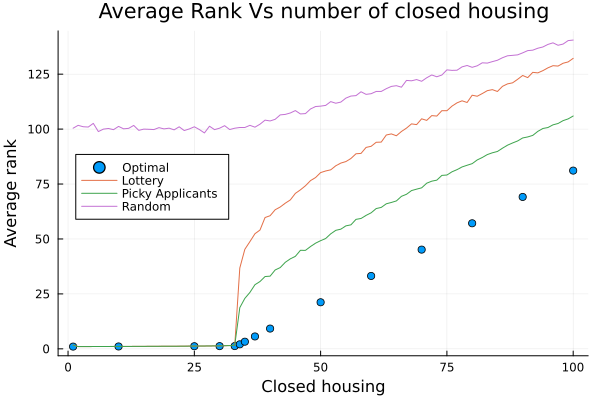

In [91]:
scatter(c, opts, label="Optimal")
plot!(1:100, util[1:100], label="Lottery", legend=:left)
plot!(1:100, util2[1:100], label="Picky Applicants")
plot!(1:100, utilrand[1:100], label="Random")
title!("Average Rank Vs number of closed housing")
xlabel!("Closed housing")
ylabel!("Average rank")

In [53]:
n = 5100 
houses = 170
caps = zeros(houses+1)
caps[1:houses] .= 30
allo_0 = (houses + 1) * ones(Int32, n)
rand_all!(allo_0, caps)
prefs = generate_prefs(n,houses)

171×5100 Matrix{Float64}:
 103.0   81.0   47.0  107.0   76.0  …  113.0   68.0   40.0  146.0   80.0
  11.0  118.0  169.0   11.0   96.0     107.0   36.0   69.0   52.0   67.0
  62.0  167.0   96.0   32.0   27.0      64.0    1.0   46.0   63.0   29.0
 123.0   80.0   31.0  142.0  111.0      48.0   71.0   36.0   85.0   71.0
 110.0   34.0    3.0   85.0  132.0     155.0  115.0  153.0   80.0  166.0
  44.0   89.0   17.0   87.0  107.0  …  135.0  134.0  164.0  169.0   22.0
 151.0   39.0  106.0   73.0  100.0      12.0   97.0   12.0   64.0  133.0
  34.0  142.0    4.0  140.0  153.0      33.0   32.0  145.0   37.0  110.0
 113.0   52.0   84.0  100.0    8.0      65.0   31.0  162.0   17.0   99.0
 143.0  152.0   94.0  170.0   55.0      81.0   87.0   39.0  142.0  170.0
   ⋮                                ⋱    ⋮                         
  74.0  111.0  160.0   83.0   39.0      98.0  121.0  143.0  145.0  131.0
  80.0   25.0   86.0  154.0   58.0      61.0   77.0   82.0  140.0  124.0
 131.0   96.0  130.0   22.0   

In [54]:
model = Model(HiGHS.Optimizer)
all2 = zeros(houses+1, n )
#@variable(model, 0 <= all2[1:houses+1, 1:n] <= 1 )
@variable(model, all2[1:houses+1, 1:n], Bin)
@objective(model, Min, sum( all2 .* prefs) / n )
for i=1:n
    @constraint(model,  sum(all2[1:houses+1, i]) == 1)
end 
# for i=1:n 
#     @constraint(model, all2[1:houses, i]' * prefs[1:houses, i] <= prefs[all[i], i] )
# end 
for j=1:houses
    @constraint(model,  sum(all2[j, 1:n]) <= caps[j] )
end 
optimize!(model)


Running HiGHS 1.5.1 [date: 1970-01-01, git hash: 93f1876e4]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
5270 rows, 872100 cols, 1739100 nonzeros
5270 rows, 872100 cols, 1739100 nonzeros
Objective function is integral with scale 5100

Solving MIP model with:
   5270 rows
   872100 cols (872100 binary, 0 integer, 0 implied int., 0 continuous)
   1739100 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   0               inf                  inf        0      0      0         0    43.4s
 T       0       0         0   0.00%   0               1.074509804      100.00%        0      0      0      7231    56.5s

Solving report
  Status            Optimal
  Primal bound      1.07450980392
  Dual bound        1.07450980392
  Gap        

In [58]:
objective_value(model)

1.0745098039215686

In [87]:
"""
    vecToMat!(vec, mat)
"""
function vecToMat!(vec, mat)
    n = length(vec) 
    for i= 1:n
        h = vec[i] 
        mat[h, i] = 1 
    end 
 end

vecToMat!

In [88]:
mat0 = zeros(houses+1, n)
vecToMat!(allo_0, mat0)

In [90]:
sum(  prefs .* mat0 )/n, (houses+1)/2

(85.01803921568627, 85.5)

In [92]:
model = Model(HiGHS.Optimizer)
lambda = 0
@variable(model, 0 <= all2[1:houses+1, 1:n] <= 1 )
@variable(model, t )

@objective(model, Min, sum(all2 .* prefs) + lambda*t )
@constraint(model, [t; vec(all2 - mat0) ] in MOI.NormOneCone(length(vec(all2)) + 1 ))
for i=1:n
    @constraint(model,  sum(all2[1:houses+1, i]) == 1)
end 
for i=1:n
    @constraint(model, sum(all2[1:houses+1, i] .* prefs[1:houses+1, i]) <= sum(mat0[1:houses+1, i] .* prefs[1:houses+1, i]) )
end 
for j=1:houses
    @constraint(model,  sum(all2[j, 1:n]) <= caps[j] )
end 


In [93]:
optimize!(model)


Running HiGHS 1.5.1 [date: 1970-01-01, git hash: 93f1876e4]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
10370 rows, 872100 cols, 2611200 nonzeros
10370 rows, 872100 cols, 2611200 nonzeros
Presolve : Reductions: rows 10370(-1744201); columns 872100(-872101); elements 2611200(-4360501)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 5100(20400) 4s
       5561     5.4600000000e+03 Pr: 0(0) 6s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 5561
Objective value     :  5.4600000000e+03
HiGHS run time      :          8.69


In [78]:
all3 = copy(value.(all2))
sum(prefs .* all3)/n , norm(vec(mat0 - all3), 1 )

(2.1198, 8858.0)

In [67]:
all4 = copy(value.(all2))
sum(prefs .* all4) , norm(vec(mat0 - all4), 1 )

(5135.0, 9870.0)

In [71]:
flag = true 
for i=1:n 
    my_score = sum(all3[1:houses+1, i] .* prefs[1:houses+1, i])
    old_score = sum(mat0[1:houses+1, i] .* prefs[1:houses+1, i])
    if my_score > old_score 
        flag = false 
    end 
end 
flag 

true

In [74]:
sum(abs.(all4 - mat0))

9870.0

In [43]:
sum(mat0[1:houses+1, 1] .* prefs[1:houses+1, 1])

106.0

In [4]:
using Random
using Distributions
using Permutations

In [15]:
Uniform()

Uniform{Float64}(a=0.0, b=1.0)

## Cayley distance 



In [55]:
function gen_prefs(n,h, k)
    function gprefs(n,k)
        t = 0 
        pie = Permutation(n)
        while t <= k 
            i = sample(1:n)
            j = sample(1:n) 
            swap = map(i -> i , 1:n)
            swap[i] = j 
            swap[j] = i 
            swap = Permutation(swap)
            if length(cycles(pie * swap)) < length(cycles(pie))
                t += 1 
                pie = pie * swap
            end 
        end 
        return two_row(pie)[2, :] 
    end 
    prefs = zeros(h+1, n)
    for i=1:n
        kk = sample(1:k)
        prefs[1:h, i] .= gprefs(h, kk)
    end 
    prefs[h+1, :] .= h+1 
    return prefs 
end 

gen_prefs (generic function with 1 method)

In [1]:
prefs = gen_prefs(5100, 170, 5)

UndefVarError: UndefVarError: gen_prefs not defined

In [67]:
sigm = Permutation([1,6,10,4,5,2,7,8,9,3])

(1)(2,6)(3,10)(4)(5)(7)(8)(9)

In [78]:
houses = 170 
n = 5100
caps = zeros(171)
caps[1:170] .= 30 
caps[171] = Inf 
model = Model(HiGHS.Optimizer)
all2 = zeros(houses+1, n )
#@variable(model, 0 <= all2[1:houses+1, 1:n] <= 1 )
@variable(model, all2[1:houses+1, 1:n], Bin)
@objective(model, Min, sum( all2 .* prefs) / n )
for i=1:n
    @constraint(model,  sum(all2[1:houses+1, i]) == 1)
end 
# for i=1:n 
#     @constraint(model, all2[1:houses, i]' * prefs[1:houses, i] <= prefs[all[i], i] )
# end 
for j=1:houses
    @constraint(model,  sum(all2[j, 1:n]) <= caps[j] )
end 
optimize!(model)


Running HiGHS 1.5.1 [date: 1970-01-01, git hash: 93f1876e4]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
5270 rows, 872100 cols, 1739100 nonzeros
5270 rows, 872100 cols, 1739100 nonzeros
Objective function is integral with scale 5100

Solving MIP model with:
   5270 rows
   872100 cols (872100 binary, 0 integer, 0 implied int., 0 continuous)
   1739100 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   0               inf                  inf        0      0      0         0    43.7s
 T       0       0         0   0.00%   0               15.31019608      100.00%        0      0      0     82157   265.5s

Solving report
  Status            Optimal
  Primal bound      15.3101960784
  Dual bound        15.3101960784
  Gap        

In [75]:
all2 = value.(all2)

171×5100 Matrix{Float64}:
 0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  …   0.0  0.0  0.0  0.0   0.0   0.0
 0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0      0.0  0.0  0.0  0.0   0.0   0.0
 0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0      0.0  0.0  0.0  0.0   0.0   0.0
 0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0      0.0  0.0  0.0  0.0   0.0   0.0
 0.0  0.0  0.0  0.0   0.0  0.0  1.0  0.0      0.0  0.0  0.0  0.0   0.0   0.0
 0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  …   0.0  0.0  0.0  0.0   0.0   0.0
 0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0     -0.0  0.0  0.0  0.0   0.0   0.0
 0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0      0.0  0.0  0.0  0.0   0.0   0.0
 0.0  0.0  0.0  0.0  -0.0  0.0  0.0  0.0      0.0  0.0  0.0  0.0  -0.0  -0.0
 0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0      0.0  0.0  0.0  0.0   0.0   0.0
 ⋮                         ⋮              ⋱        ⋮                    
 0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0      0.0  0.0  0.0  0.0   0.0   0.0
 0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0      0.0  0.0

In [71]:
objective_value(model)

15.310196078431371

In [79]:
objective_value(model)

15.310196078431371

In [128]:
n = 10200
houses = 340
prefs = generate_prefs(n, houses )
#caps = generate_caps(houses, 30)
caps = ones(houses+1)
caps[1:houses] .= 30
caps[houses+1] = Inf 
used = zeros(houses+1)
allo = (houses + 1) * ones(Int32, n)
used[houses+1] = n  


10200

In [121]:
limited_lottery!(prefs, allo, caps, used, 3)
s = score(prefs, allo)/5100
used = zeros(houses+1)
allo = (houses + 1) * ones(Int32, n);
s

4.083137254901961

In [129]:
lottery!(prefs, allo, caps, used)
s = score(prefs, allo)/10200
used = zeros(houses+1)
allo = (houses + 1) * ones(Int32, n);
s

36.33

In [100]:
51, 19.2

In [101]:
score(prefs, allo)/5100     

85.2678431372549